<>:51: SyntaxWarning: invalid escape sequence '\O'
<>:52: SyntaxWarning: invalid escape sequence '\O'
<>:51: SyntaxWarning: invalid escape sequence '\O'
<>:52: SyntaxWarning: invalid escape sequence '\O'
C:\Users\amrsh\AppData\Local\Temp\ipykernel_22564\4243964821.py:51: SyntaxWarning: invalid escape sequence '\O'
  ax1.set_ylabel('$R_{xx}$ [k$\Omega$]', color='k')
C:\Users\amrsh\AppData\Local\Temp\ipykernel_22564\4243964821.py:52: SyntaxWarning: invalid escape sequence '\O'
  ax2.set_ylabel('$R_{xy}$ [k$\Omega$]', color='b')


Processing file: D:/05_scHB_Bsweep (01)/00_05_scHB_Bsweep (01).dat
          B        Rxx        Rxy
0   -0.5000    4.32208   -5.38807
1   -0.4924    4.31398   -5.39176
2   -0.4810    4.20944   -5.33468
3   -0.4688    4.12204   -5.26044
4   -0.4572    4.05536   -5.11665
..      ...        ...        ...
731  7.9637  725.43800 -546.37200
732  7.9757  735.97300 -552.66000
733  7.9876  749.69900 -560.31500
734  7.9988  755.54800 -561.29200
735  8.0002  766.40900 -566.45000

[736 rows x 3 columns]
Density: 6.15e+10 x 10^11 cm^-2
Mobility: 8.06e-02 x 10^3 cm^2/Vs


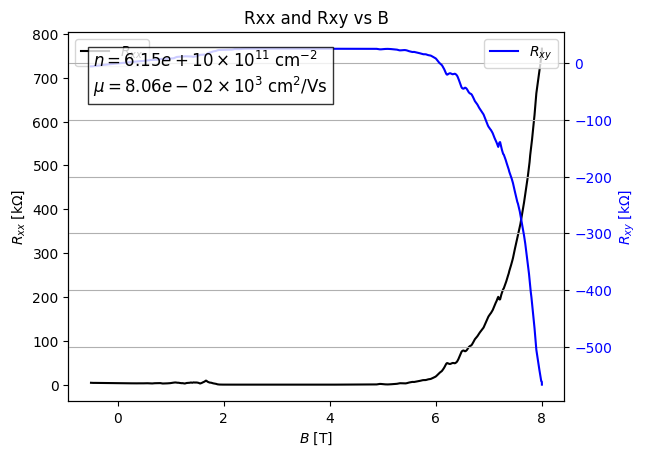

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.constants import e
from scipy.stats import linregress
import tkinter as tk
from tkinter import filedialog

def load_hall_data(file_path, encoding='latin1'):
    with open(file_path, 'r', encoding=encoding) as file:
        lines = file.readlines()

    data_start_line = None
    for i, line in enumerate(lines):
        if line.strip() == '---------':
            data_start_line = i + 1
            break

    if data_start_line is None:
        raise ValueError("Data start line not found")

    data_lines = lines[data_start_line:]
    data = []
    for line in data_lines:
        split_line = line.strip().split()
        if len(split_line) >= 7: 
            try:
                data.append([float(split_line[0]), float(split_line[4]) / 1000, float(split_line[5]) / 1000])  # Convert to kiloohms
            except ValueError:
                continue

    if len(data) == 0:
        raise ValueError("No valid data found")

    df = pd.DataFrame(data, columns=['B', 'Rxx', 'Rxy'])
    return df

def plot_hall_data(data, output_dir, output_filename, density, mobility):
    B = data['B']
    Rxx = data['Rxx']
    Rxy = data['Rxy']
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    ax1.plot(B, Rxx, 'k-', label='$R_{xx}$')
    ax2.plot(B, Rxy, 'b-', label='$R_{xy}$')
    
    ax1.set_xlabel('$B$ [T]')
    ax1.set_ylabel('$R_{xx}$ [k$\Omega$]', color='k')
    ax2.set_ylabel('$R_{xy}$ [k$\Omega$]', color='b')
    
    ax1.tick_params(axis='y', labelcolor='k')
    ax2.tick_params(axis='y', labelcolor='b')
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.title('Rxx and Rxy vs B')
    plt.grid()
    
    plt.text(0.05, 0.95, f'$n = {density:.2e} \\times 10^{{11}} \\; \\mathrm{{cm}}^{{-2}}$\n$\\mu = {mobility:.2e} \\times 10^{{3}} \\; \\mathrm{{cm}}^{{2}}/\\mathrm{{Vs}}$', 
             transform=ax1.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.savefig(os.path.join(output_dir, f"{output_filename}.png"))
    plt.show()

def calculate_density_and_mobility(data):
    B = data['B']
    Rxy = data['Rxy']
    Rxx = data['Rxx']
    
    central_region = np.abs(B) <= 0.1
    slope, intercept, r_value, p_value, std_err = linregress(B[central_region], Rxy[central_region])
    density = 1 / (slope * e * 1e-4)  
    Rxx_B0 = Rxx[np.abs(B).argmin()]
    mobility = 3 / (Rxx_B0 * density * e * 1e-5)  
    
    return density / 1e11, mobility / 1e3 

def main():
    root = tk.Tk()
    root.withdraw()  

    file_path = filedialog.askopenfilename(parent=root, filetypes=[('Data files', '*.dat')])
    if not file_path:
        raise ValueError("No file selected")

    output_dir = filedialog.askdirectory(parent=root, title="Select Output Directory")
    if not output_dir:
        raise ValueError("No output directory selected")

    root.destroy()  

    print(f"Processing file: {file_path}")
    data = load_hall_data(file_path)
    print(data)  

    density, mobility = calculate_density_and_mobility(data)
    print(f"Density: {density:.2e} x 10^11 cm^-2")
    print(f"Mobility: {mobility:.2e} x 10^3 cm^2/Vs")

    output_filename = os.path.splitext(os.path.basename(file_path))[0]
    
    plot_hall_data(data, output_dir, output_filename, density, mobility)

if __name__ == "__main__":
    main()
